### STEP 1. 載入相關函式庫

In [1]:
# 屏蔽Jupyter的warning訊息
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
import sys
import os
import math

# 多維向量處理相關函式庫
import numpy as np

# 圖像處理相關函式庫
import cv2
import matplotlib.pyplot as plt

# 深度學習相關函式庫
import tensorflow as tf

# 專案相關函式庫
import facenet
import detect_face

# 模型序列化函式庫
import pickle

### STEP 2. 設定相關設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 模型的資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# MTCNN的模型
MTCNN_MODEL_PATH = os.path.join(MODEL_PATH, "mtcnn")

# FaceNet的模型
FACENET_MODEL_PATH = os.path.join(MODEL_PATH, "facenet","20170512-110547","20170512-110547.pb")

# Classifier的模型
SVM_MODEL_PATH = os.path.join(MODEL_PATH, "svm", "lfw_svm_classifier.pkl")

# 訓練/驗證用的圖像資料目錄
TEST_IMG_PATH = os.path.join(DATA_PATH, "test_images")

In [3]:
# 臉類別(ImageClass)的列表與圖像路徑
dataset = facenet.get_dataset(TEST_IMG_PATH)

###  STEP 3. 構建MTCNN的模型來偵測人臉位置

In [4]:
print('Creating networks and loading parameters')
sess = tf.Session()
with sess.as_default():
    pnet, rnet, onet = detect_face.create_mtcnn(sess, MTCNN_MODEL_PATH)

Creating networks and loading parameters
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### 設定人臉偵測模型所需的相關參數

In [5]:
minsize = 20  # 最小的臉部的大小
threshold = [0.6, 0.7, 0.7]  # 三個網絡(P-Net, R-Net, O-Net)的閥值
factor = 0.709  # scale factor

margin = 44 # 在裁剪人臉時的邊框margin
image_size = 182 # 160 + 22

**人臉位置偵測**

In [6]:
filepath = dataset[0].image_paths[1]
filename = os.path.splitext(os.path.split(dataset[0].image_paths[0])[1])
image = plt.imread(filepath)

In [10]:
bounding_boxes, _ = detect_face.detect_face(image, minsize, pnet, rnet, onet, threshold, factor)

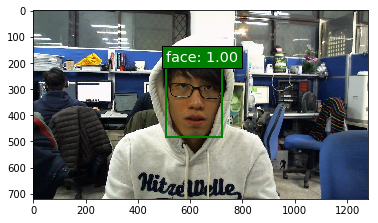

In [11]:
plt.imshow(image)
color = (0, 255, 0)
current_axis = plt.gca()
for box in bounding_boxes:
    xmin = int(box[0])
    ymin = int(box[1])
    xmax = int(box[2])
    ymax = int(box[3])
    label = '{}: {:.2f}'.format('face', box[4])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})
    
    # 進行裁剪以及大小的轉換
    cropped_temp = image[ymin:ymax, xmin:xmax, :]
    img = cv2.resize(cropped_temp, (image_size, image_size))


### STEP 4. 人臉特徵擷取

In [12]:
# 載入Facenet模型
print('Loading feature extraction model')
modeldir =  FACENET_MODEL_PATH #'/..Path to Pre-trained model../20170512-110547/20170512-110547.pb'
facenet.load_model(modeldir)

images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
embedding_size = embeddings.get_shape()[1]
# 打印"人臉特徵向量"的向量大小
print("Face embedding size: ", embedding_size)

#影像前處理
img = facenet.prewhiten(img)
img = facenet.crop(img, False, image_size)
#特徵擷取
feed_dict = {images_placeholder: np.expand_dims(img, axis=0), phase_train_placeholder: False}
emb_array = sess.run(embeddings, feed_dict=feed_dict)

print(feed_dict[images_placeholder].shape)

Loading feature extraction model
Model filename: /home/share/John/face-recognition/model/facenet/20170512-110547/20170512-110547.pb
Face embedding size:  128
(1, 182, 182, 3)


### STEP 5. 預測
**讀取特徵、labels**

In [13]:
# 反序列化相關可重覆使用的資料

# "標籤(label)對應到人臉名稱的字典的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels_dict.pkl'), 'rb') as emb_lables_dict_file:
    emb_labels_dict = pickle.load(emb_lables_dict_file)
print("人臉embedding labels dict: {}, type: {}".format(len(emb_labels_dict), type(emb_labels_dict)))

人臉embedding labels dict: 424, type: <class 'dict'>


**載入模型、預測**

In [14]:
classifier_filename = SVM_MODEL_PATH

with open(classifier_filename, 'rb') as f:
    cf = pickle.load(f)
    predict = cf[0].predict(emb_array[0,None])
    print('Input image :', 'Woody_Lin')
    print('Predict :', emb_labels_dict[predict[0]])
# img = plt.imread(os.path.join(IMG_IN_PATH, emb_labels_dict[emb_labels[pred_img]], img_names[pred_img]+'.jpg'))
# plt.imshow(img)

Input image : Woody_Lin
Predict : Woody_Lin


**顯示結果**

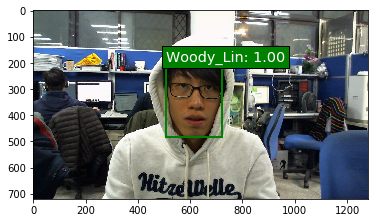

In [15]:
plt.imshow(image)
color = (0, 255, 0)
current_axis = plt.gca()
for box in bounding_boxes:
    xmin = int(box[0])
    ymin = int(box[1])
    xmax = int(box[2])
    ymax = int(box[3])
    label = '{}: {:.2f}'.format(emb_labels_dict[predict[0]], box[4])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})